In [1]:
import numpy as np
import numpy.linalg as la
import random
import scipy as sp
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from scipy import stats
from numpy.random import default_rng

import seaborn as sns
sns.set_theme(style="whitegrid")

fs=24
lw=4

## Example 1: Advertising 
- Consider $m$ demographic groups (audiences) that we want to advertise to, with a target number of *impressions* or *views* for each group, $b$
- To reach these groups, we purchase advertising in $n$ different channels (e.g., different web publishers, radio, print,\ldots ), in amounts that given as a vector $x\in \mathbb{R}^n$.
- The matrix $A\in \mathbb{R}^{m\times n}$ specifies the number of impressions in each group per dollar spending in the channels---i.e., entry $a_{ij}$ is the number of impressions in group $i$ per dollar spent on advertising in channel $j$.
    - The $j$--th column of $A$ gives the effectiveness or reach (in impressions per dollar) for channel $j$. 
    - The $i$--th row of $A$ shows which media demographic group $i$ is exposed to.
- **Goal**: find $x$ such that $\|Ax-b\|_2^2$ is as small as possible (minimized) -- i.e., we want to solve the optimization problem
$$\min_{x}\|Ax-b\|_2^2$$


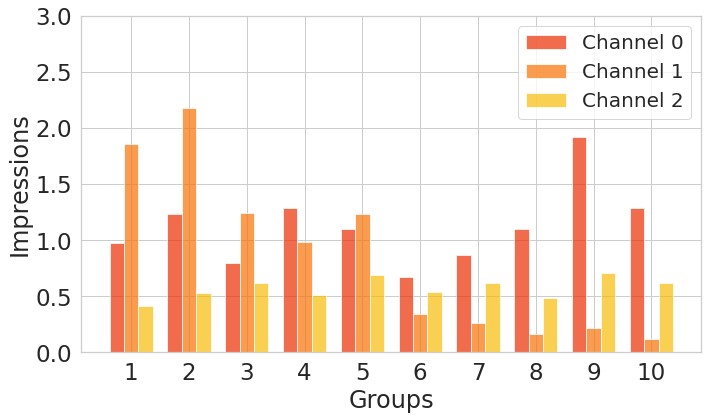

In [2]:
#advertising budget
A = np.array([[.97,1.86,.41],
              [1.23,2.18,.53],
              [.8,1.24,.62],
              [1.29,.98,.51],
              [1.1,1.23,.69],
              [.67,.34,.54],
              [.87,.26,.62],
              [1.1,.16,.48],
              [1.92,.22,.71],
              [1.29,.12,.62]])

# List to plot
channel1 = A[:,0]
channel2 = A[:,1]
channel3 = A[:,2]

# Some properties for the plot
alpha = 0.7
bar_width = 0.25
# LAbels for the both axis
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Groups', fontsize=fs)
plt.ylabel('Impressions', fontsize=fs)
plt.tick_params(labelsize=fs-1)
colors=['xkcd:tomato red', 'xkcd:orange', 'xkcd:golden rod']
# bar-plot
for i in range(3):
    if i == 0:
        shift=-1
    elif i == 2:
        shift=1
    else:
        shift=0
    plt.bar(np.arange(1,1+len(A[:,i])) + shift*bar_width, A[:,i], bar_width, align='center', alpha=alpha, color=colors[i], label='Channel {}'.format(i))
plt.xticks([i for i in range(1,1+len(A[:,i]))])
plt.ylim([0,3])


plt.legend(fontsize=fs-4, loc=1)
plt.tight_layout()
plt.show()

#### Finding the Least Squares Solution
There are many ways to find the least squares solution. Here we will compute the manual solution as we saw in the lecture, as well as compare that to the `numpy.linalg.lstsq` solution from `numpy`.

Recall from lecture we said the least squares solution is given by
$$x^\ast=A^\dagger b=(A^\top A)^{-1}A^\top b$$

In [3]:
m,n = np.shape(A)
print("Shape of A : ({},{})".format(m,n))
b = 1e3 * np.ones(m)
x = la.lstsq(A,b, rcond=None)[0]
print("numpy.linalg least squares solution: ", x)
print()
x_ = la.inv(A.T@A)@A.T@b
print("manual least squares solution      : ", x_)

Shape of A : (10,3)
numpy.linalg least squares solution:  [  62.07662454   99.98500403 1442.83746254]

manual least squares solution      :  [  62.07662454   99.98500403 1442.83746254]


In [4]:
rms = lambda x: np.sqrt(np.mean(np.square(x))) 
print("RMS value : ", rms(np.matmul(A,x) - b))

RMS value :  132.6381902632653


Let's plot the views vector that best approximates the target of one million impressions per group.

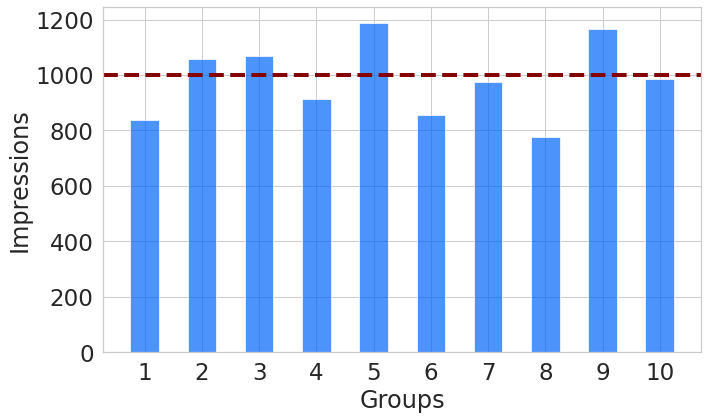

In [5]:
# Some properties for the plot
alpha = 0.7
bar_width = 0.5
# LAbels for the both axis
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Groups', fontsize=fs)
plt.ylabel('Impressions', fontsize=fs)
plt.tick_params(labelsize=fs-1)

# bar-plot
plt.bar(np.arange(1,1+len(A[:,i])), A@x_, bar_width, align='center', alpha=alpha, color='xkcd:bright blue')
plt.xticks([i for i in range(1,1+len(A[:,i]))])
plt.axhline(y=1000, color='xkcd:dark red', linestyle='--', lw=lw)
plt.tight_layout()
plt.show()

We will revisit this example when we get to constrained least squares wherein we add a constraint like a total budget.

Below we can randomly generate the $A$ matrix and see how that changes the solution.

In [6]:
A = np.random.uniform(low=0,high=2, size=(10,3))
print("A : \n", A, "\n ")
m,n = np.shape(A)
print("Shape of A : ({},{})".format(m,n))
b = 1e3 * np.ones(m)
x = la.lstsq(A,b, rcond=None)[0]
print()
print("numpy.linalg least squares solution: ", x)
print()
x_ = la.inv(A.T@A)@A.T@b
print("manual least squares solution      : ", x_)

A : 
 [[1.16868725 0.75321018 1.57746559]
 [0.98178449 1.50144446 0.60854437]
 [1.09737486 1.1059077  0.62932609]
 [1.80069901 1.864732   0.53950847]
 [0.10321915 0.39822722 1.37801703]
 [1.23191664 0.47953164 1.17749685]
 [0.19144374 1.77729132 1.40529664]
 [0.41528946 0.49055062 1.90944156]
 [0.26620626 0.37039228 1.75307239]
 [1.2095821  1.65328896 0.04790562]] 
 
Shape of A : (10,3)

numpy.linalg least squares solution:  [245.5409824  280.47711555 430.91767983]

manual least squares solution      :  [245.5409824  280.47711555 430.91767983]


## Example 2: Illumination

A set of $n$ lamps illuminates an area that we divide into m regions or pixels. We let $\ell_i$ denote the lighting level in region $i$, so the $m$-dimensional vector $\ell$ gives the illumination levels across all regions. We let $p_i$ denote the power at which lamp $i$ operates, so the $n$-dimensional vector $p$ gives the set of lamp powers. (The lamp powers are nonnegative and also must not exceed a maximum allowed power, but we ignore these issues here.)

The vector of illumination levels is a linear function of the lamp powers, so we have $$\ell = Ap$$ for some $m \times n$ matrix $A$. 
- The $j$-th column of $A$ gives the illumination pattern for lamp $j$---i.e., the illumination when lamp $j$ has power one and all other lamps are off. 
- The $i$-th row of $A$ gives the sensitivity of pixel $i$ to the $n$ lamp powers.
- We will assume that $A$ has linearly independent columns (and therefore is tall). 

**Goal**:  Find lamp powers that result in a desired illumination pattern $b$ such that $b=\alpha\boldsymbol{1}$, which is uniform illumination with value $\alpha$ across the area. In other words, we see $p$ so that $Ap\approx b$. Hence the least squares problem is
$$\min_{p}\|Ap-b\|_2^2$$
and we know the solution is
$$p^\ast=A^\dagger b=(A^\top A)^{-1}A^\top b$$


**Problem setup**: Consider a $25\times 25$ grid with $m=625$ pixels each representing a $1$m square. The lamps are at various heights ranging from $3$m
to $6$m, and at the positions shown in the figure. The illumination decays with an
inverse square law, so $A_{ij}$ is proportional to $d_{ij}^{-2}$ where $d_{ij}$ is the distance between the center of the pixel and the lamp position. The matrix $A$ is scaled so that when all lamps have power one, the average illumination level is one. The desired illumination pattern is $\boldsymbol{1}$---i.e., uniform with value one.

In [7]:
#10 lamps each with an x,y,z position -- z is height above the floor
lamps = np.array([[4.1,20.4,4],
                   [14.1,21.3,3.5],
                   [22.6,17.1,6],
                   [5.5,12.3,4.0],
                   [12.2,9.7,4.0],
                   [15.3,13.8,6],
                   [21.3,10.5,5.5],
                   [3.9,3.3,5.0],
                   [13.1,4.3,5.0],
                   [20.3,4.2,4.5]])
n = np.shape(lamps)[0]
print("number of lamps n : ",n)
N = int(max(lamps.flatten())+2.4) 
print("grid size         : ", N)
m = N**2 
print("pixel density m   : ", m)

number of lamps n :  10
grid size         :  25
pixel density m   :  625


Now to set the problem up we need to create the $A$ matrix, which means we need to populate it with the inverse distances squares as stated in the problem statement. To this end, we will use the `numpy.full` command. It creates an array of a specified size filled with a particular value. 

In [8]:
## numpy.full
np.full(N,1.0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.])

Now, we create a vector with the coordiantes of the pixel centers. And populate the $A$ matrix. Recall that `lamps` contains the location of the ten lamps.

In [9]:
#an m x 2 matrix with coordinates of pixel centers 
pixels = np.hstack((np.vstack([np.vstack(np.arange(.5,N,1)) for i in range(N)]),np.vstack([np.vstack(np.full(N,.5+i)) for i in range(N)])))
print("shape of pixels array : ", np.shape(pixels))
print()

# populate A
A = np.zeros((m,n))
for i in range(m):
    for j in range(n):
        A[i,j] = 1.0/np.square(la.norm(np.hstack([pixels[i,:],[0]]) - lamps[j,:]))
A = (m/sum(A)) * A



shape of pixels array :  (625, 2)



Let's first set the powers all to one---i.e., $p=\boldsymbol{1}$. 

rms score :  9.258278678473806


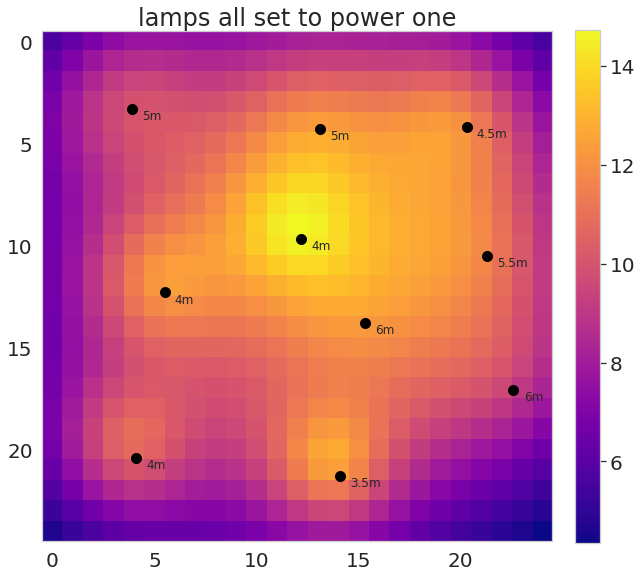

In [10]:
ones=np.ones((10,))
y=A@ones
y=y.reshape(25,25)
plt.figure(figsize=(10,10))
plt.grid(False)
pixel_plot=plt.imshow(y, cmap='plasma') #, interpolation='nearest')
cbar=plt.colorbar(pixel_plot,fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=fs-4)
heights=['4m','3.5m','6m','4m','4m','6m','5.5m','5m','5m','4.5m']
for i in range(0,10):
    plt.annotate(heights[i], xy=(lamps[i,0]+0.5,lamps[i,1]+0.5))
    plt.scatter(lamps[i,0],lamps[i,1], s=100, c='black', marker='o')
plt.tick_params(labelsize=fs-4)
plt.title("lamps all set to power one", fontsize=fs)


rmsLS = rms(A@ones - 1)

print('rms score : ', rmsLS)

Now let's do the least squares solution. 

least squares solution : 
 [[0.14713155]
 [0.09734554]
 [0.21194941]
 [0.09069832]
 [0.01108386]
 [0.02033356]
 [0.01831807]
 [0.15925451]
 [0.08821742]
 [0.1359583 ]]
rms score :  0.1403904813427606


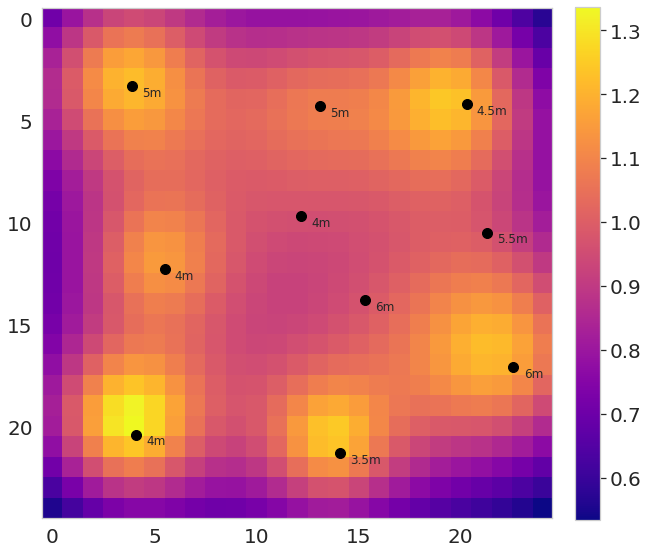

In [11]:
x = la.lstsq(A,np.ones((m,1)),rcond=None)[0]
print("least squares solution : \n", x)
rmsLS = rms(A@x - 1)

print('rms score : ', rmsLS)

y=A@x
y=y.reshape(25,25)
plt.figure(figsize=(10,10))
plt.grid(False)
heights=['4m','3.5m','6m','4m','4m','6m','5.5m','5m','5m','4.5m']
for i in range(0,10):
    plt.annotate(heights[i], xy=(lamps[i,0]+0.5,lamps[i,1]+0.5))
    plt.scatter(lamps[i,0],lamps[i,1], s=100, c='black', marker='o')
pixel_plot=plt.imshow(y, cmap='plasma') #, interpolation='nearest')
cbar=plt.colorbar(pixel_plot,fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=fs-4) 
plt.tick_params(labelsize=fs-4)

## Example 3:  Sparse Leastsquares
What if the $A$ matrix is now what we call sparse---i.e., this means that many entries are zero. Least squares problems with sparse $A$ arise in several applications and can be solved more efficiently, for example by using a QR factorization tailored for sparse matrices (cf. page 190 of <span style="color:magenta">VMLS</span> or the algorithm in $\S$12.1).

Another simple approach for exploiting sparsity of $A$ is to solve the normal equations
$$A^\top A\hat{x}=A^\top b$$
by solving a larger (but sparse) system of equations,
$$\begin{bmatrix} 0 & A^\top\\ A & I\end{bmatrix}\begin{bmatrix}\hat{x}\\ \hat{y}\end{bmatrix}=\begin{bmatrix}0\\b\end{bmatrix}$$
This is a square set of $m+n$ linear equations. Its coefficient matrix is sparse when $A$ is sparse. If $(\hat{x}, \hat{y})$ satisfies these equations, it is easy to see that $\hat{x}$ satisfies the above equation; conversely, if $\hat{x}$ satisfies the normal equations, $(\hat{x}, \hat{y})$ satisfies the above equations with $\hat{y} = b − A\hat{x}$. Any method for solving a sparse system of linear equations can be used to solve the above expression.


In [12]:
rng = default_rng() # default random number generator
rvs = stats.poisson(25,loc=10).rvs # function that generates random values according to the poisson distribution
S = sparse.random(10,3, density=0.2, random_state=rng,data_rvs=rvs)

print("Sparse matrix : \n", S.A)
A=S.A
m,n = np.shape(A)
x = la.lstsq(A,b, rcond=None)[0]
print("numpy.linalg least squares solution: ", x)
print()
x_ = la.inv(A.T@A)@A.T@b
print("manual least squares solution      : ", x_)

M = np.vstack((np.hstack((np.zeros((n,n)),A.T)), np.hstack((A,np.eye(m)))))
v = np.concatenate((np.zeros((3,)),b))
x_s = la.inv(M.T@M)@M.T@v
print("solution via normal equations : ", x_s[0:3])

Sparse matrix : 
 [[44.  0. 41.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [36.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [32.  0.  0.]
 [ 0.  0.  0.]
 [ 0. 38. 41.]
 [ 0.  0.  0.]]
numpy.linalg least squares solution:  [29.31034483 33.93829401 -7.0647603 ]

manual least squares solution      :  [29.31034483 33.93829401 -7.0647603 ]
solution via normal equations :  [29.31034483 33.93829401 -7.0647603 ]
